In [114]:
import pandas as pd
from scipy.io import arff
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from skopt import BayesSearchCV
from skopt.space import Integer
from skopt.space import Real
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# Load the data

In [117]:
df_cvd = pd.read_csv('Cardiovascular_Disease_Dataset.csv')

In [119]:
df_cvd.head(20)

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1
5,148462,24,1,1,173,0,0,0,161,0,4.7,3,2,1
6,168686,79,1,2,130,240,0,2,157,0,2.5,2,1,1
7,170498,52,1,0,127,345,0,0,192,1,4.9,1,0,0
8,188225,62,1,0,121,357,0,1,138,0,2.8,0,0,0
9,192523,61,0,0,190,181,0,1,150,0,2.9,2,0,1


In [121]:
#drop patient ID
df_cvd = df_cvd.drop('patientid', axis=1)

# Exploratory Data Analysis

**Looking closer at the slope feature, there is an issue with it** 
The data card on Kaggle states that there should be three values for slope, but we see a spurious additional value of 0 

It is not immediately clear what these 0 values represent as a fourth category for slope is not standard in the medical literature either.  They could be a special category created for this dataset and not described on the data card, missing values or signify an error in the population of the data.
df_cvd.value_counts('slope')


In [125]:
df_cvd['slope'].value_counts()

slope
2    322
1    299
3    199
0    180
Name: count, dtype: int64

There is a significant number of 0 values, we cannot immediately assume an error or that this data is simply missing
Let's look at how they correlate with the target class


Text(0.5, 1.0, 'Distribution of target class by slope category')

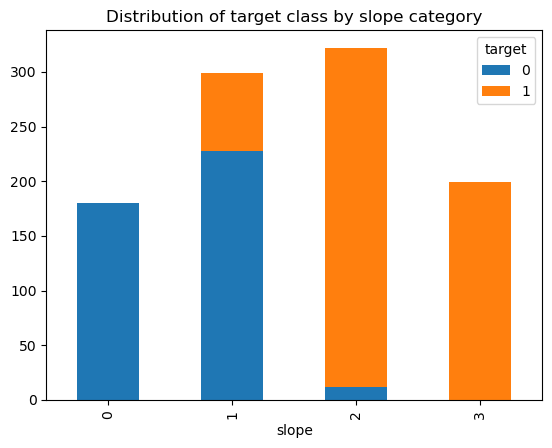

In [128]:

pd.crosstab(df_cvd['slope'], df_cvd['target']).plot(kind='bar', stacked=True)

plt.title('Distribution of target class by slope category')

Although the rows with slope = 0 all also have target = 0,  we cannot infer anything from this.  This might well be a legitimate category for slope and therefore, there may be useful data contained in it.  However, there is a danger that IF they are not legitimate values, the algorithm will learn a meaningless relationship.
Conclusion: we do not have enough evidence to keep it so we will remove all rows with slope = 0. This leaves us with 820 rows of data, still enough to proceed with training the dataset


In [131]:
#remove slope
df_cvd = df_cvd[df_cvd['slope']!=0]
df_cvd

,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,31,1,1,199,0,0,2,136,0,5.3,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,25,0,1,197,0,0,0,195,0,1.0,3,0,1
995,48,1,2,139,349,0,2,183,1,5.6,2,2,1
996,47,1,3,143,258,1,1,98,1,5.7,1,0,0
997,69,1,0,156,434,1,0,196,0,1.4,3,1,1


In [133]:
#Check for missing values
df_cvd.isnull().sum().sum()


0

In [135]:
#Now let us analyse the data further, look at data types and inspect the balance of the test set with respect to the target and other key variables

print(df_cvd.dtypes)

num_true = np.sum(df_cvd['target']==1)
num_false = np.sum(df_cvd['target']==0)

print("number of patients who have cvd: ", num_true)
print("number of patients who do not have cvd: ", num_false)


age                    int64
gender                 int64
chestpain              int64
restingBP              int64
serumcholestrol        int64
fastingbloodsugar      int64
restingrelectro        int64
maxheartrate           int64
exerciseangia          int64
oldpeak              float64
slope                  int64
noofmajorvessels       int64
target                 int64
dtype: object
number of patients who have cvd:  580
number of patients who do not have cvd:  240


**Although the dataset is balanced in favour of the positive cases (70% vs 30%), the imbalance is not extreme and imbalance in this direction is preferable than the other way round given we are more interested in recall in this situation i.e. identifying all patients who do have cardiovascular disease.**

Let's define the different column types based on the information in the data card

In [138]:
#define the categorical, numeric, ordinal and binary variables to prepare for preprocessing

categorical_cols=['chestpain','restingrelectro','slope']
ordinal_cols = ['noofmajorvessels']
numeric_cols =  ['age','restingBP','serumcholestrol','maxheartrate','oldpeak']
binary_cols = [col for col in df_cvd.columns if df_cvd[col].nunique() == 2 and col != 'target']
print(binary_cols)

['gender', 'fastingbloodsugar', 'exerciseangia']


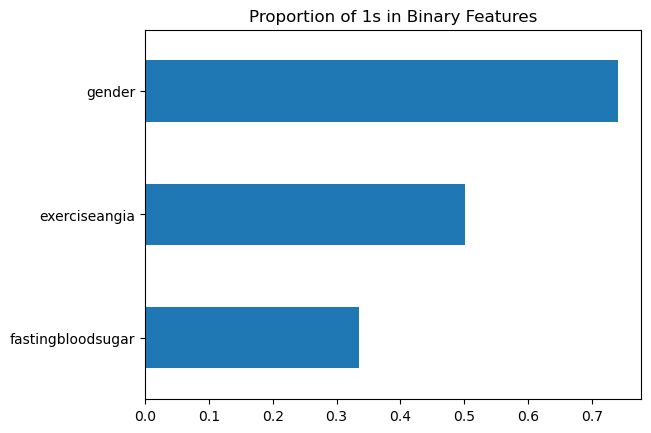

In [140]:
#Look at the distribution of each binary variable

df_cvd[binary_cols].mean().sort_values().plot(kind='barh')
plt.title('Proportion of 1s in Binary Features')
plt.show()


In [142]:
df_cvd['gender'].value_counts()

gender
1    607
0    213
Name: count, dtype: int64

**We see that gender is heavily skewed**  There are 607 instances of male patients and 213 instances of female patients.  This raises a question about how to treat the gender variable.  Females represent about 26% of the data, so there is a notable imbalance but not extreme, Let's check how significant the gender attribute is when it comes to the distribution of the target variable.  We'll do this for all binary variables for comparison.


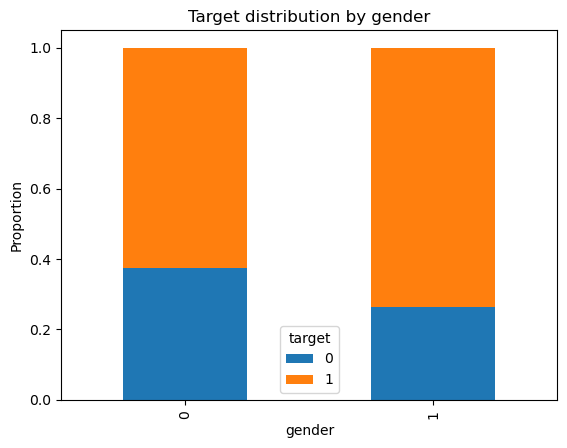

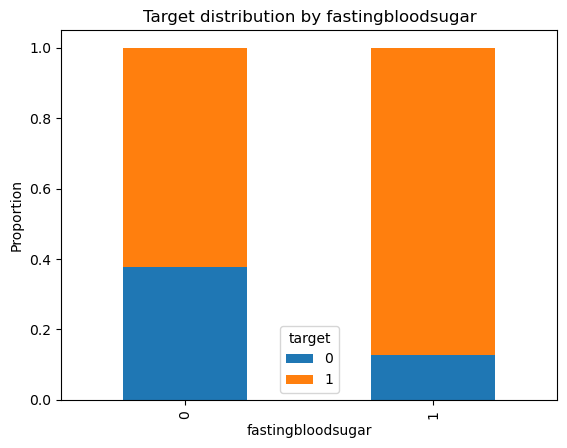

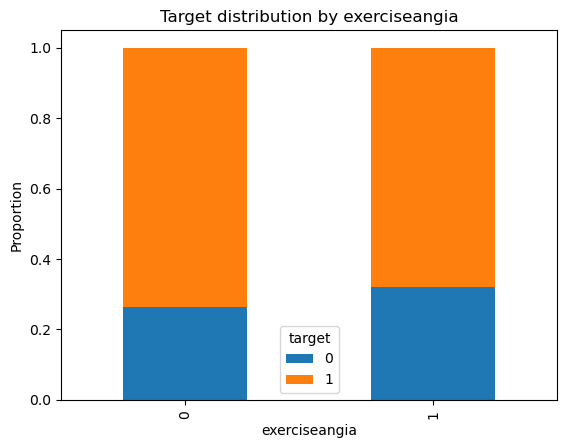

In [145]:
for col in binary_cols:
    pd.crosstab(df_cvd[col], df_cvd['target'], normalize='index').plot(kind='bar', stacked=True)
    plt.title(f"Target distribution by {col}")
    plt.ylabel('Proportion')
    plt.show()


**Conclusion: The distribution of the target variable is not hugely different within the two gender groups**

**It does not look like gender alone is hugely predictive of the target variable Given all the above, we do not expect this imbalance in data to cause a huge issue in the learning stage and there may well be useful clinical patterns inherent in the data.**

**So we will keep it but given that the training data is heavily biased towards males, we need to dig into the accuracy scores later down the line**


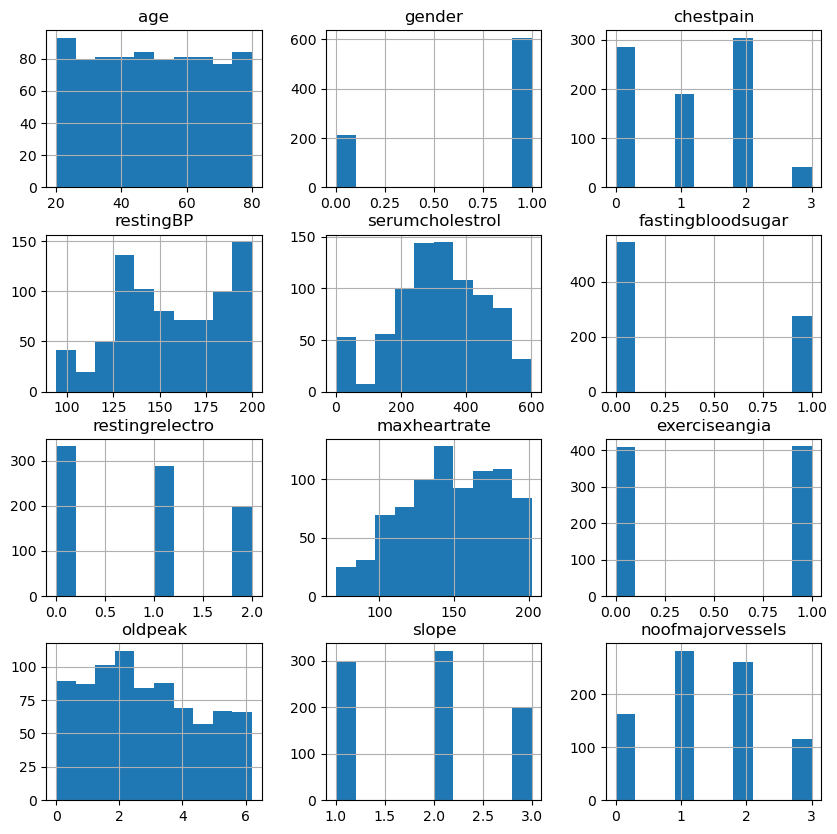

In [148]:
df_cvd_inputs = df_cvd.drop('target', axis=1)
hist = df_cvd_inputs.hist(figsize=(10,10))

In [149]:
#Summarise the numerical columns

df_cvd[numeric_cols].describe()

,age,restingBP,serumcholestrol,maxheartrate,oldpeak
count,820.000000,820.000000,820.000000,820.000000,820.000000
mean,49.106098,156.021951,319.256098,147.228049,2.833293
std,17.632241,28.860652,140.199597,32.231086,1.717923
min,20.000000,94.000000,0.000000,71.000000,0.000000
25%,34.000000,133.000000,235.000000,124.000000,1.400000
50%,48.500000,155.000000,330.500000,148.000000,2.600000
75%,64.000000,184.000000,424.750000,175.000000,4.300000
max,80.000000,200.000000,602.000000,202.000000,6.200000


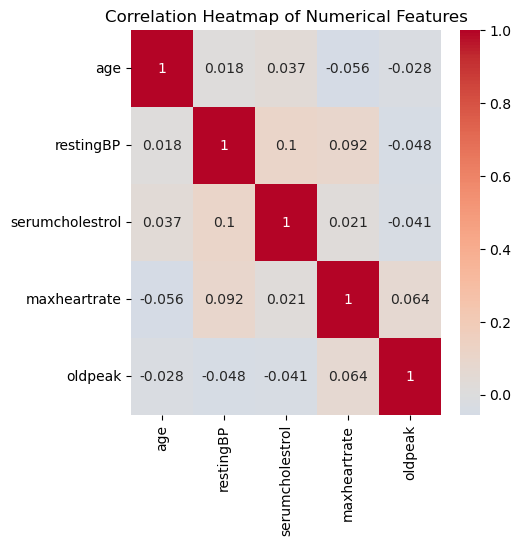

In [150]:
#How do the numeric variables correlate to each other?

corr = df_cvd[numeric_cols].corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

**Observations on numerical variables**

- We see a wide range of scales for the numeric values, expect to scale them during a preprocessing step
- Serum cholesterol of 0 looks unlikely but it could be that the value was a very small positive value which is possible and it is rounded to 0
- Oldpeak can be 0 in reality
- There are no strong correlations so no immediate concern about multicolinearity affecting the predictive capability of any linear models we use later


# Split data to enable training, evaluation and testing

Before any data preprocessing, we need to split our test data into train and test sets so that any preprocessing is only using the information in the train set. This avoids data leakage from the test set into the training and initial evaluation of the model.  The test set can then be used to assess how the model performs on truly unseen data.

In [157]:
X = df_cvd.drop('target',axis=1)
y = df_cvd['target']

X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=4)


In [159]:
#Recap of the columns and their types so we can decide how to treat each one

print("Categorical cols: ",categorical_cols)
print("Numeric cols: ", numeric_cols)
print("Binary cols: ", binary_cols)
print("Ordinal cols: ", ordinal_cols)

Categorical cols:  ['chestpain', 'restingrelectro', 'slope']
Numeric cols:  ['age', 'restingBP', 'serumcholestrol', 'maxheartrate', 'oldpeak']
Binary cols:  ['gender', 'fastingbloodsugar', 'exerciseangia']
Ordinal cols:  ['noofmajorvessels']


**Approach for preprocessing**
  
We will approach the preprocessing step with the objective of getting maximum performance from each of the models we train.  So it may be necessary to preprocess data slightly differently for the different models in order to take advantage of their relative strengths and avoid model-specific issues.

Approach: we will compose different preprocessing routes for the tree-based and non-tree based models.  

The only difference will be that when we do OneHotEncoding for categorical variables, we will NOT drop a column for tree-based models but we WILL for models such as logistic and SVM where colinearity could pose an issue.

In all preprocessing routes, numerical variables will be processed with a robust scaler whereas binary and ordinal values will be passed through as is.

In [162]:
#Define two preprocessors

preprocessor_non_tree = ColumnTransformer([('cat drop one', OneHotEncoder(drop='first'),categorical_cols),('numerical',RobustScaler(),numeric_cols),('bool', 'passthrough', binary_cols), ('ord','passthrough',ordinal_cols)])
preprocessor_tree = ColumnTransformer([('cat no drop', OneHotEncoder(drop=None), categorical_cols),('numerical',RobustScaler(),numeric_cols),('bool', 'passthrough', binary_cols),('ord','passthrough',ordinal_cols)])



In [164]:
#Preprocessing for logistic regression, SVM and KNN i.e. non-tree models
#First, we fit the preprocessor ONLY on the training data and transform it
#Then, we use this to transform the test data

X_train_processed_non_tree = preprocessor_non_tree.fit_transform(X_train)
X_test_processed_non_tree = preprocessor_non_tree.transform(X_test)

column_names_out_non_tree = preprocessor_non_tree.get_feature_names_out()

#Create dataframe with the transformed inputs and populate meaningful column names back
X_train_df_transformed_non_tree = pd.DataFrame(X_train_processed_non_tree, columns = column_names_out_non_tree)
X_train_df_transformed_non_tree.head()


,cat drop one__chestpain_1,cat drop one__chestpain_2,cat drop one__chestpain_3,cat drop one__restingrelectro_1,cat drop one__restingrelectro_2,cat drop one__slope_2,cat drop one__slope_3,numerical__age,numerical__restingBP,numerical__serumcholestrol,numerical__maxheartrate,numerical__oldpeak,bool__gender,bool__fastingbloodsugar,bool__exerciseangia,ord__noofmajorvessels
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.413793,0.15,-1.772666,0.538462,0.931034,1.0,0.0,0.0,2.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.241379,0.29,0.771313,-0.384615,0.206897,1.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.517241,-0.39,-0.430311,-0.807692,0.448276,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.103448,0.27,-1.772666,-0.846154,0.655172,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.931034,-0.29,-1.772666,0.000000,-0.586207,1.0,0.0,0.0,1.0


In [166]:
#Preprocessing for tree models

X_train_processed_tree = preprocessor_tree.fit_transform(X_train)
X_test_processed_tree = preprocessor_tree.transform(X_test)

column_names_out_tree = preprocessor_tree.get_feature_names_out()


X_train_df_transformed_tree = pd.DataFrame(X_train_processed_tree, columns = column_names_out_tree)
X_train_df_transformed_tree.head()


,cat no drop__chestpain_0,cat no drop__chestpain_1,cat no drop__chestpain_2,cat no drop__chestpain_3,cat no drop__restingrelectro_0,cat no drop__restingrelectro_1,cat no drop__restingrelectro_2,cat no drop__slope_1,cat no drop__slope_2,cat no drop__slope_3,numerical__age,numerical__restingBP,numerical__serumcholestrol,numerical__maxheartrate,numerical__oldpeak,bool__gender,bool__fastingbloodsugar,bool__exerciseangia,ord__noofmajorvessels
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.413793,0.15,-1.772666,0.538462,0.931034,1.0,0.0,0.0,2.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.241379,0.29,0.771313,-0.384615,0.206897,1.0,1.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.517241,-0.39,-0.430311,-0.807692,0.448276,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.103448,0.27,-1.772666,-0.846154,0.655172,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.931034,-0.29,-1.772666,0.000000,-0.586207,1.0,0.0,0.0,1.0



##### Below we define some common functions to report on performance later down the line

**Notes on cross-validate function**

This function will use a stratified k-fold cross validation whereby the distribution of the target variable within each fold of data will be representative of the distribution in the overall dataset.

In the below cross_validate function we choose three important scores to return:
1. the overall accuracy - what proportion of all instances were classified correctly?
2. the recall - of all the truly positive instances, what proportion were identified as positive by the model?
3. F1 score - a balanced interpretation of model performance, taking into account both precision (of all the instances that the model classified as positive, what proportion was actually positive?) and recall (per above).

We continue to focus on these three scores going forward, including when reporting test results.

**Notes on models**

Below, we have identified five popular models for classification tasks.  These have been chosen with the objective of simplicity and interpretability in mind.  By training several models, we will be able to compare performance of the models with respect to a number of factors and narrow down the preferred models later down the line.

In [169]:
#Common functions to measure and report on performance

#function to perform stratified k-fold cross validation (cv) on a model
def cross_validate_model(clf, X, y):
    #given this is a binary classifier with cv=5, this will use stratified k-fold cv
    #define a few different scores to measure
    scores = cross_validate(clf, X, y_train, cv=5,
                        scoring=('accuracy','recall', 'precision', 'f1', 'balanced_accuracy'),
                        return_train_score=True)
    
    #focus on three scores for now
    test_accuracy = scores['test_accuracy']
    test_recall = scores['test_recall']
    test_f1 = scores['test_f1']

    
    #Calculate the mean and std for each score
    mean_cv_accuracy = np.mean(test_accuracy)
    std_cv_accuracy = np.std(test_accuracy)
    
    mean_cv_recall = np.mean(test_recall)
    std_cv_recall = np.std(test_recall)

    mean_cv_f1 = np.mean(test_f1)
    std_cv_f1 = np.std(test_f1)

    return mean_cv_accuracy, std_cv_accuracy, mean_cv_recall, std_cv_recall, mean_cv_f1, std_cv_f1


#function to report performance based on a set of predicted target values and actual target values
def report_test_results(y_true, y_predicted):
    
    accuracy = accuracy_score(y_true,y_predicted)
    recall = recall_score(y_true,y_predicted)
    precision = precision_score(y_true,y_predicted)
    f1 = f1_score(y_true,y_predicted)
    balanced_accuracy = balanced_accuracy_score(y_true,y_predicted)

    #Choose three scores to focus on, as above
    return accuracy, recall, f1


#Dictionary to reset and store models for use later
#Set random state where applicable for reproducability and ease of interpreting the notebook and readme files (seed not applicable in SVM and LR under default settings)


models = {'Logistic':LogisticRegression(),
             'SVM':SVC(),
             'Decision tree':DecisionTreeClassifier(random_state=1),
             'Random forest':RandomForestClassifier(random_state=1),
          'KNN':KNeighborsClassifier()}

#Empty lists to store cv, test and gender results
cv_results = []
test_results = []
gender_results = []

#Empty dataframes for cv, test and gender results
df_cv = pd.DataFrame()
df_test=pd.DataFrame()
df_gender = pd.DataFrame()


In [171]:
#Loop through the models using tree data or non-tree data depending on the model, cross validate and collect the cross validation results

for name, model in models.items():
    if name in ['Logistic','SVM','KNN']:
        accuracy, std_accuracy, recall, std_recall, f1, std_f1 = cross_validate_model(model, X_train_processed_non_tree, y_train)
    else:
        accuracy, std_accuracy, recall, std_recall, f1, std_f1 = cross_validate_model(model, X_train_processed_tree, y_train)

    #Update cv_results
    cv_results.append({'Model':name,'CV accuracy':accuracy, 'CV accuracy std': std_accuracy, 
                       'CV recall':recall, 'CV recall std':std_recall, 'CV f1':f1, 'CV f1 std':std_f1})


**In the following CV results dataframe, I have chosen to sort by the recall score descending.  I am focusing on recall given the nature of the problem - namely, our main goal is to identify as many patients as possible who may have cardiovascular disesase so that medical intervention can be made.  We will continue to track other aspects of the model scores too**


In [174]:
#Capture the cv results in a dataframe for ease of comparison

df_cv = pd.DataFrame(cv_results)
df_cv.sort_values(by=['CV recall','CV f1'], ascending=False)

,Model,CV accuracy,CV accuracy std,CV recall,CV recall std,CV f1,CV f1 std
3,Random forest,0.961925,0.014338,0.978165,0.011864,0.972831,0.010239
0,Logistic,0.955806,0.011154,0.971596,0.011048,0.968411,0.007865
2,Decision tree,0.958848,0.016424,0.969422,0.014370,0.970443,0.011785
1,SVM,0.943581,0.015009,0.969398,0.012706,0.960015,0.010144
4,KNN,0.932940,0.014732,0.934376,0.018235,0.951032,0.010607


- From this we observe that:
    - the models are returning similar results on the whole
    - KNN appears to have the worst predictive performance, given it has the lowest scores.  The different scores have relatively high standard deviations compared to other models, which gives us less confidence in the evaluation of its performance.
    - the decision tree model shows less variance than other results which helps establish its predictive capability (although it has returned a lower recall score than three other models).
 
We will investigate the performance of all models on the test set.

**Furthermore, as noted above it is critical that we inspect model performance on the male and female subsets of the test data.  This is due to the identified imbalance in the number of training instances in the respective gender categories with male training instances outnumbering female ones by a ratio of about 3:1**


In [177]:
#Defining the training and test data for the male and female subgroups 

#Training data
train_female_indices = np.where(X_train['gender']==0)
train_male_indices = np.where(X_train['gender']==1)

train_female_indices_rows = train_female_indices[0]
train_male_indices_rows = train_male_indices[0]

y_train_female = y_train.iloc[train_female_indices_rows]
y_train_male = y_train.iloc[train_male_indices_rows]

#Test data
test_female_indices = np.where(X_test['gender']==0)
test_male_indices = np.where(X_test['gender']==1)

test_female_indices_rows = test_female_indices[0]
test_male_indices_rows = test_male_indices[0]


y_test_female = y_test.iloc[test_female_indices_rows]
y_test_male = y_test.iloc[test_male_indices_rows]


In [179]:
#Now we will train the models on the full training set and predict results on the test set

for name, model in models.items():
    if name in ['Logistic','SVM','KNN']:
        X_train_processed_rows = X_train_processed_non_tree
        X_test_processed_rows = X_test_processed_non_tree

    else: 
        X_train_processed_rows = X_train_processed_tree
        X_test_processed_rows = X_test_processed_tree
            
    model.fit(X_train_processed_rows, y_train)
    
    y_predicted = model.predict(X_test_processed_rows)
    accuracy, recall, f1 = report_test_results(y_test, y_predicted)
    
    #extract the male and female subsets of the predicted and actual test y values
    y_predicted_female = y_predicted[test_female_indices_rows]
    y_predicted_male = y_predicted[test_male_indices_rows]
    accuracy_male, recall_male, f1_male = report_test_results(y_test_male, y_predicted_male)
    accuracy_female, recall_female, f1_female = report_test_results(y_test_female, y_predicted_female)


    #Update test results and gender results lists
    test_results.append({'Model':name,'Test recall': recall,'Test f1':f1,'Test accuracy':accuracy})
    gender_results.append({'Model':name,'Female recall':recall_female, 'Male recall':recall_male, 
                           'Female f1':f1_female, 'Male f1':f1_male,
                           'Female accuracy':accuracy_female, 'Male accuracy':accuracy_male
                          })


### Test results

In [181]:
#View test results 
df_test = pd.DataFrame(test_results)
df_test.sort_values(by=['Test recall', 'Test f1'],ascending=False)


,Model,Test recall,Test f1,Test accuracy
1,SVM,0.975610,0.983607,0.975610
3,Random forest,0.967480,0.979424,0.969512
0,Logistic,0.959350,0.975207,0.963415
2,Decision tree,0.934959,0.962343,0.945122
4,KNN,0.918699,0.953586,0.932927


### Gender results

In [183]:
#View gender results, add columns for the score deltas

df_gender = pd.DataFrame(gender_results)

df_gender['Recall delta'] = df_gender['Female recall'] - df_gender['Male recall']
df_gender['F1 delta'] = df_gender['Female f1'] - df_gender['Male f1']
df_gender['Accuracy delta'] = df_gender['Female accuracy'] - df_gender['Male accuracy']

df_gender


,Model,Female recall,Male recall,Female f1,Male f1,Female accuracy,Male accuracy,Recall delta,F1 delta,Accuracy delta
0,Logistic,0.896552,0.978723,0.945455,0.983957,0.925,0.975806,-0.082172,-0.038503,-0.050806
1,SVM,0.931034,0.989362,0.947368,0.994652,0.925,0.991935,-0.058327,-0.047284,-0.066935
2,Decision tree,0.931034,0.936170,0.947368,0.967033,0.925,0.951613,-0.005136,-0.019665,-0.026613
3,Random forest,0.896552,0.989362,0.928571,0.994652,0.900,0.991935,-0.092810,-0.066081,-0.091935
4,KNN,0.827586,0.946809,0.905660,0.967391,0.875,0.951613,-0.119222,-0.061731,-0.076613


### Checkpoint on gender scores

- Focusing on the recall metrics still, we see that the delta (bias towards male population) is highest for KNN (12%) and lowest for decision trees (0.5%).
- For decision trees, the recall within each class is still very high - at about 94%.
- SVM has the second lowest delta, albeit quite a bit higher than the decision tree. 
- The random forest model has resulted in a noteworth delta too of ~9% for both the recall and overall accuracy scores.

### Cross validation and test results side by side

In [186]:
#Combine cv and test results into one table

df_results_summary = pd.merge(df_cv, df_test, on='Model')
df_results_summary.sort_values(by=['Test recall', 'Test f1'],ascending=False)

,Model,CV accuracy,CV accuracy std,CV recall,CV recall std,CV f1,CV f1 std,Test recall,Test f1,Test accuracy
1,SVM,0.943581,0.015009,0.969398,0.012706,0.960015,0.010144,0.975610,0.983607,0.975610
3,Random forest,0.961925,0.014338,0.978165,0.011864,0.972831,0.010239,0.967480,0.979424,0.969512
0,Logistic,0.955806,0.011154,0.971596,0.011048,0.968411,0.007865,0.959350,0.975207,0.963415
2,Decision tree,0.958848,0.016424,0.969422,0.014370,0.970443,0.011785,0.934959,0.962343,0.945122
4,KNN,0.932940,0.014732,0.934376,0.018235,0.951032,0.010607,0.918699,0.953586,0.932927


### Interpretation of CV and test scores

- We see svm has returned highest across all scores and so far is suggestive of highest performance including our key score of recall across all models
- Decision trees have not returned the highest scores but we will keep them in the mix given:
    - the female-male deltas calculated above are consistently lowest across all score types
    - the CV and test scores are still quite close to the other models
    - they have the potential to be very intuitive for clinicians

Taking these two models, we will now progress to hyperparameter tuning.  We will use BayesOptCV as a method for optimising the hyperparameter space as Bayesian Optimisation is known to be an efficient approach here.

## Hyperparameter tuning

Taking these two models, we will now progress to hyperparameter tuning. We will use **BayesOptCV** as a method for optimising the hyperparameter space as Bayesian Optimisation is known to be an efficient approach here.

In [209]:
#Choose three most interpretable and balanced models to tune hyperparameters before choosing an overall best model
#Randome forest has returned the join highest recall and accuracy and the hightest f1.  Let's tune this as there are several hyperparameters to work with and we can see what improvements 
#can be made given an already very high baseline performance

best_models = {}
best_parameters = {}
best_train_results = []
best_test_results = []

param_dict = { 
'Decision tree': {'max_depth':Integer(3,10), 'min_samples_leaf':Integer(2,5), 'max_features':[None, 'log2', 'sqrt'],
                  'splitter':['best','random'], 'ccp_alpha':Real(0.0,0.03)},
'SVM':{'kernel':['linear','poly','rbf','sigmoid'], 'C':(0.001,5)}
}

#initialise list of classifiers
clf_models = {
'Decision tree': DecisionTreeClassifier(random_state=2),
'SVM': SVC(),
}

for name, model in clf_models.items():

    #We will select 'recall' as the score to optimise for in light of the discussion on identifying postive cases above
    opt = BayesSearchCV(model,param_dict[name],scoring='recall',random_state=2)

    if name in ['Logistic','SVM','KNN']:
        X_train_processed_rows = X_train_processed_non_tree
        X_test_processed_rows = X_test_processed_non_tree
                
    else: 
        X_train_processed_rows = X_train_processed_tree
        X_test_processed_rows = X_test_processed_tree
        
    #run cv on all training data
    opt.fit(X_train_processed_rows, y_train)
    
    #return the best estimator
    best_estimator = opt.best_estimator_
    best_score = opt.best_score_
    best_params = opt.best_params_
    print(f"{name}: best params:{best_params}, recall score={best_score}")

    best_models[name] = best_estimator
    best_parameters[name] = best_params

    #Check how the best estimator performs on the training data
    y_train_pred = opt.predict(X_train_processed_rows)
    y_train_pred_female = y_train_pred[train_female_indices_rows]
    y_train_pred_male = y_train_pred[train_male_indices_rows]
    
    #Check how the best estimator performs on the test data
    y_test_pred = opt.predict(X_test_processed_rows)
    y_test_pred_female = y_test_pred[test_female_indices_rows]
    y_test_pred_male = y_test_pred[test_male_indices_rows]

    #Gather training results
    accuracy_train, recall_train, f1_train = report_test_results(y_train, y_train_pred)
    accuracy_female_train, recall_female_train, f1_female_train = report_test_results(y_train_female, y_train_pred_female)
    accuracy_male_train, recall_male_train, f1_male_train = report_test_results(y_train_male, y_train_pred_male)

    #Gather test results
    accuracy_test, recall_test, f1_test = report_test_results(y_test, y_test_pred)
    accuracy_male_test, recall_male_test, f1_male_test = report_test_results(y_test_male, y_test_pred_male)
    accuracy_female_test, recall_female_test, f1_female_test = report_test_results(y_test_female, y_test_pred_female)


    #Add results to train and test results lists
    best_train_results.append({'Model': name, 'Tuned accuracy':accuracy_train, 'Tuned recall':recall_train, 'Tuned f1':f1_train,
                              'Tuned recall male':recall_male_train, 'Tuned recall female':recall_female_train})
    
    best_test_results.append({'Model': name, 'Tuned accuracy':accuracy_test, 'Tuned recall':recall_test, 'Tuned f1':f1_test,
                              'Tuned recall male':recall_male_test, 'Tuned recall female':recall_female_test})



Decision tree: best params:OrderedDict({'ccp_alpha': 0.0, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'splitter': 'best'}), recall score=0.9847109412326803


/opt/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 'rbf'] before, using random point [0.9903761279497407, 'linear']
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 'sigmoid'] before, using random point [1.2371509330963102, 'rbf']
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 'sigmoid'] before, using random point [1.266321133964902, 'linear']
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.001, 'sigmoid'] before, using random point [0.3187337632659576, 'sigmoid']
  warnings.warn(


SVM: best params:OrderedDict({'C': 0.001, 'kernel': 'rbf'}), recall score=1.0


### Results of hyperparameter tuning on training data

In [220]:
#Create tables for train results from hyperparameter optimisation
best_train_results_tuned = pd.DataFrame(best_train_results)
best_train_results_tuned.sort_values(by='Tuned recall',ascending=False)


,Model,Tuned accuracy,Tuned recall,Tuned f1,Tuned recall male,Tuned recall female
0,Decision tree,0.884146,1.0,0.923232,1.0,1.0
1,SVM,0.696646,1.0,0.821204,1.0,1.0


### Results of hyperparameter tuning on test data

In [211]:
#Create table for test results from hyperparameter optimisation

best_test_results_tuned = pd.DataFrame(best_test_results)
best_test_results_tuned.sort_values(by='Tuned recall',ascending=False)


,Model,Tuned accuracy,Tuned recall,Tuned f1,Tuned recall male,Tuned recall female
0,Decision tree,0.871951,1.0,0.921348,1.0,1.0
1,SVM,0.750000,1.0,0.857143,1.0,1.0


## Interpretation of hyperparameter tuning results and selection of best model

- **For the decision tree model:**
  - the results are balanced both across the train and test sets AND across the different performance measures.
  - the overall accuracy on both the train and test sets is still relatively high at close to 90% while the tuning has resulted in an increased recall in both the train and test sets
  - although 100% recall might be suggestive of overfitting, we do not see a significant discrepancy between the training and test results
<br>
<br>
- **For the support vector machine model:**
  - we have incurred a signifcant drop in overall accuracy for a relatively small boost to the recall
  - there is slightly more variation across train and test sets for this model

**In light of the above, and the fact that decision trees lend themselves to intuitive interpretation of results, we will proceed to analyse the fitted decision tree in more detail**


In [260]:
#Identify the best estimator, retrieve cross validation sores, fit on training data and test on test data
best_model_results = []

best_model = DecisionTreeClassifier(ccp_alpha=0.0, max_depth=3, max_features ='sqrt', min_samples_leaf=5, splitter= 'best', random_state=2)

#mean_cv_accuracy, std_cv_accuracy, mean_cv_recall, std_cv_recall, mean_cv_f1, std_cv_f1 = cross_validate_model(best_model, X_train_processed_tree, y_train)

cross_val_recall = cross_val_score(best_model, X_train_processed_tree, y_train, scoring='recall', cv=5)
cross_val_accuracy = cross_val_score(best_model, X_train_processed_tree, y_train, scoring='accuracy', cv=5)
cross_val_f1 = cross_val_score(best_model, X_train_processed_tree, y_train, scoring='f1', cv=5)

mean_cross_val_accuracy = np.mean(cross_val_accuracy)
mean_cross_val_recall = np.mean(cross_val_recall)
mean_cross_val_f1 = np.mean(cross_val_f1)


best_model.fit(X_train_processed_tree, y_train)
y_pred = best_model.predict(X_test_processed_tree)
test_accuracy, test_recall, test_f1 = report_test_results(y_test, y_pred)


best_model_results.append({'Mean cv accuracy':mean_cross_val_accuracy, 'Mean cv recall':mean_cross_val_recall, 'Mean cv f1': mean_cross_val_f1, 
                         'Test accuracy':test_accuracy, 'Test recall':test_recall, 'Test f1':test_f1})


# best_model_results.append({'Mean cv accuracy':mean_cv_accuracy, 'Mean cv recall':mean_cv_recall, 'Mean cv f1': mean_cv_f1, 
#                          'Test accuracy':test_accuracy, 'Test recall':test_recall, 'Test f1':test_f1})


## Analysis of best model

In [258]:
best_model_results_df = pd.DataFrame(best_model_results)
best_model_results_df


,Mean cv accuracy,Mean cv recall,Mean cv f1,Test accuracy,Test recall,Test f1
0,0.884155,0.984711,0.922071,0.871951,1.0,0.921348


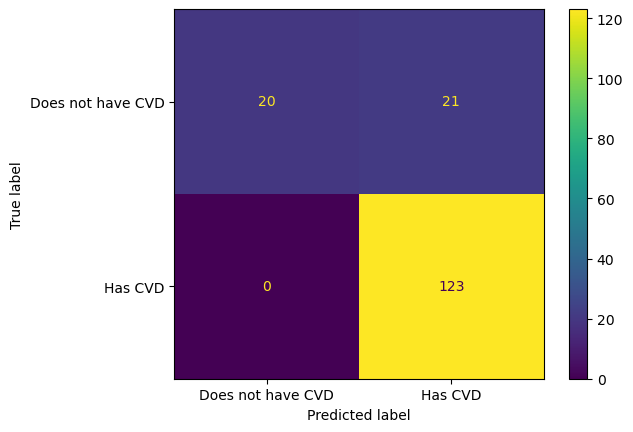

In [239]:

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Does not have CVD', 'Has CVD'] )

Comparing the tables of cross validation and test results before and after hyperparameter tuning reveals that:
> - The average cross validation recall has improved from 97% to 98% while the test recall has increased from 93% to 100%.
> - In the course of tuning for the best possible recall score, the cross validation F1 score (which gives us a balanced perspective of performance in postive case identification) has decreased from 97% to 92% while the test F1 score has reduced from 96% to 92%.
> - The overall accuracy displays an even larger reduction from 96% to 88% during cross validation and from 95% to 87% during testing

The confusion matrix for the test results is seen above.  One key observation is that the true negative rate of 49% stands out as a metric which we have traded off to increase our chances of catching all positive cases.  This means in reality about one in two patients who do not have cardiovascular disease could get flagged as having the disease - which is a figure we might accept if we were being on the conservative side of proactive and timely disease management. 

Text(0.5, 1.0, 'Decision Tree for the prediction of cardiovascular disease')

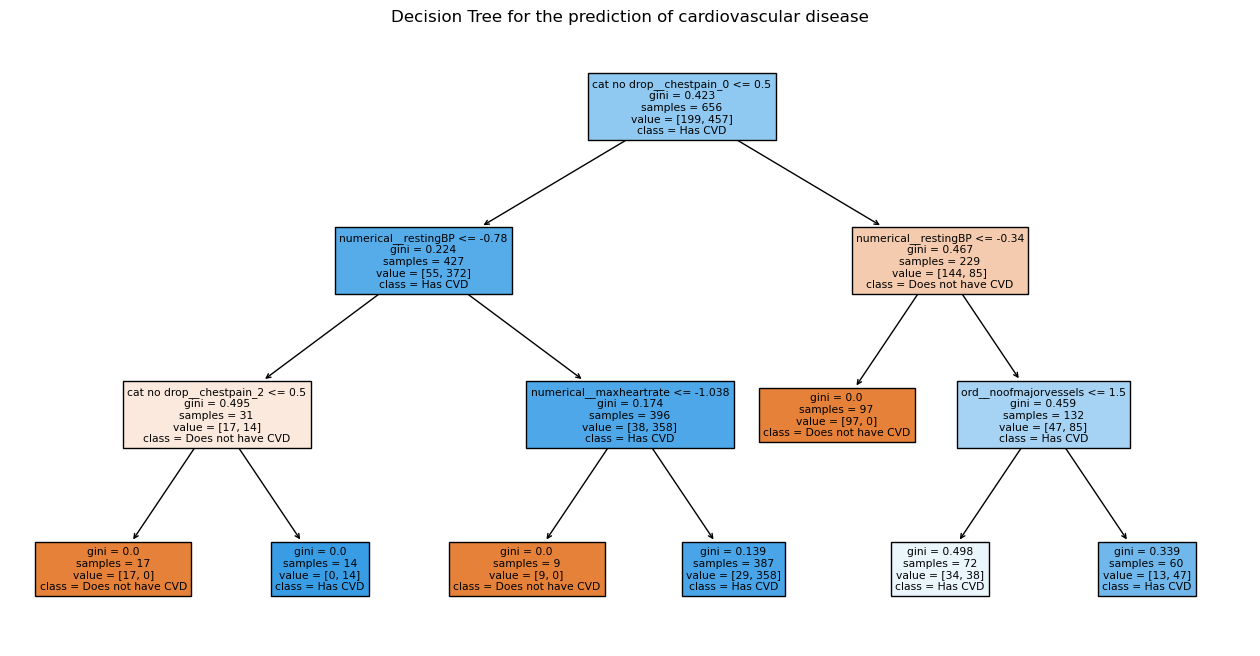

In [272]:
#Visualise the best decision tree 

best_tree_params = best_parameters['Decision tree']
best_tree = best_models['Decision tree']
feature_list = column_names_out_tree
classes = ['Does not have CVD','Has CVD']

plt.figure(figsize=(16, 8))
tree.plot_tree(best_tree,feature_names=feature_list, class_names=classes,filled=True )
plt.title("Decision Tree for the prediction of cardiovascular disease")

### Interpretation of decision tree

- This decision tree can be considered interpretable to a clinician such as a GP or cardiovascular specialist, in line with one of our key goals at the start of this project.  Its interpretability is supported by its minimal depth of 3 meaning no node has a very low number of samples and suggests relatively low chance of overfitting.
- The Gini values of the terminal nodes (measure of impurity) vary noticeably.  Some terminal nodes have a 0 impurity whereas others (e.g. the last but one terminal node in the tree has a high Gini of 0.498)
- The purity of all terminal nodes with decision "Does not have CVD" is reflective of the 100% recall achieved by this model on the training data.
- According to this tree, the key variables in the prediction of CVD are the chestpain category, the resting BP, the max heart rate and the number of major vessels coloured by fluroscopy.
- With respect to the chest pain category, the model is specifically interested in whether a patient's chest pain is in category 0 (typical angina pain) or category 2 (non-anginal pain).
- The presence or not of chestpain of category type 0 and the value of resting BP together are particularly informative


### SHAP analysis

To support our interpretation of the results, we will look at some SHAP plots.   SHAP values can help to:
- explain the relative importance of the predictors in determining the classification
- provide insight into how those predictors individually affect the eventual classification
- explain interaction between features by seeing how a variable's SHAP values are affected by the value of another variable

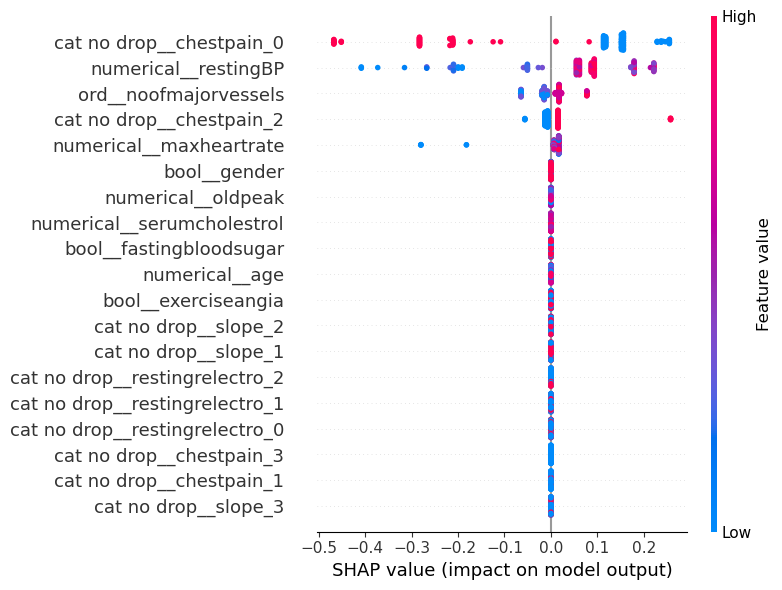

In [277]:
import shap

explainer = shap.TreeExplainer(best_tree)
shap_values = explainer.shap_values(X_test_processed_tree)
X_test_df = pd.DataFrame(X_test_processed_tree, columns=feature_list)

shap.summary_plot(shap_values[:,:,1], X_test_df, show=False)

fig = plt.gcf()
fig.set_size_inches(8, 6) 
plt.tight_layout()
plt.show()


### Interpretation of the SHAP summary plot

- The summary plot above again highlights the key predictors we identified in the decision tree - namely, chestpain category 0, resting BP, number of major vessels colored by fluroscopy, max heart rate
- The chestpain category 0 and restingBP variables both exhibit the highest magnitude SHAP values suggesting they have the ability to strongly push the prediction of a given instance into the positive class or into the negative class.
- Chestpain category 2 and max heart rate are interesting - whilst many SHAP values for these predictors are lower in magnitude, there are certain cases where their SHAP values are of a much higher magnitude.  It looks like that in certain situations, having a low max heart rate strongly predicts 'Does not have cardiovascular diesease' whereas the presence of category 2 chestpain strong predicts 'Has cardiovascular disease' in certain cases.
- The fact there are a wide range of values for the SHAP values of chestpain category 0 and restingBP suggest other factors are at play when it comes to understanding the influence of these two variables - let's dive into this point with the help of some dependence plots.

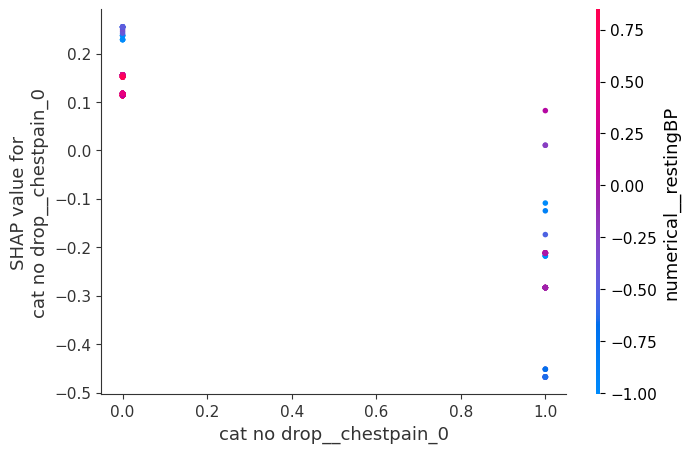

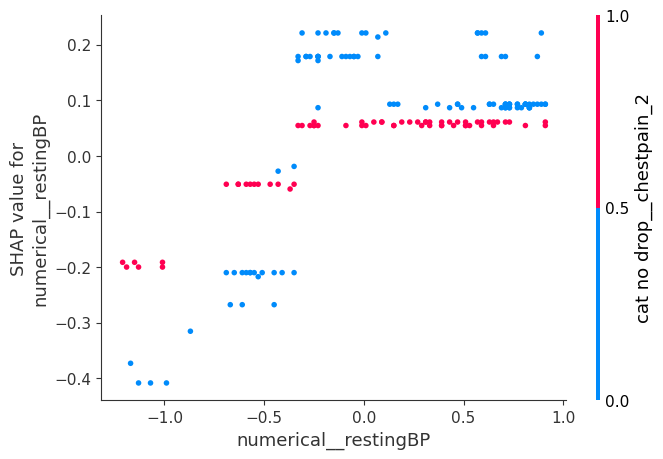

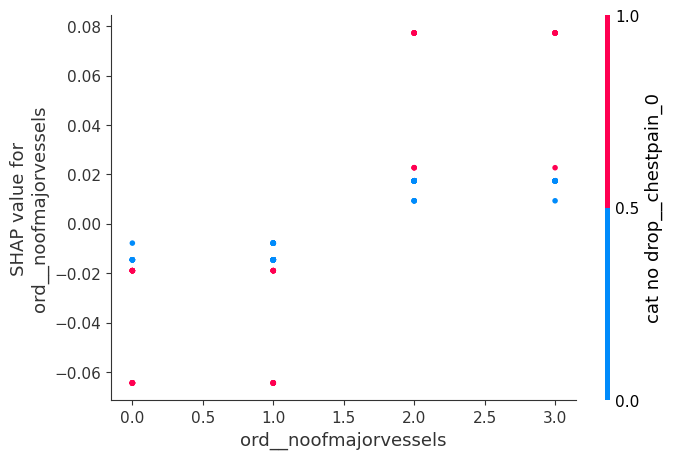

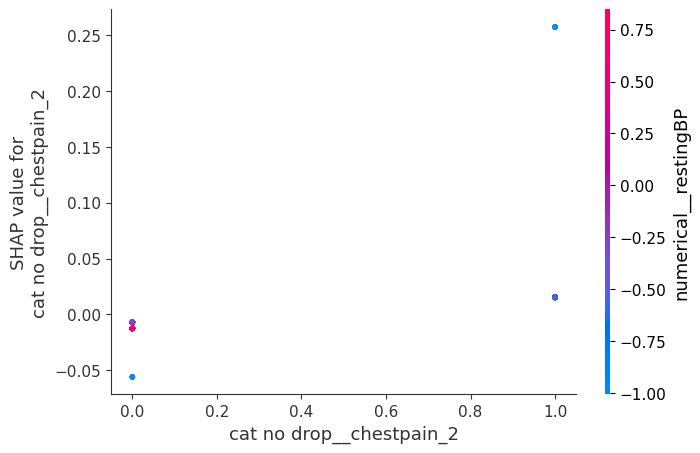

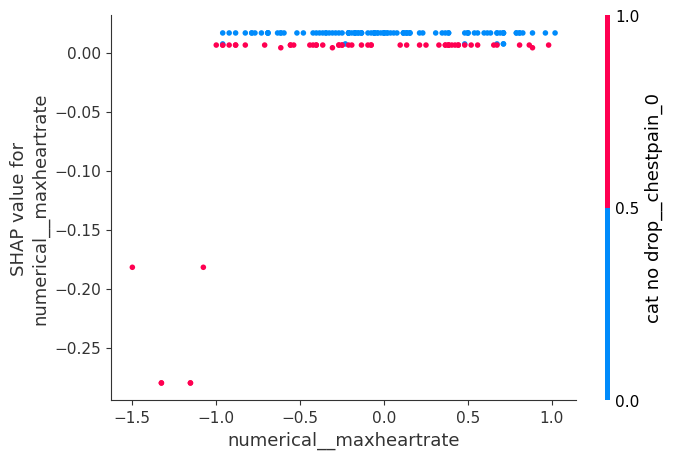

In [289]:
shap_vals_positive_class = shap_values[:, :, 1]

shap.dependence_plot("cat no drop__chestpain_0", shap_vals_positive_class, X_test_df, interaction_index='auto')
shap.dependence_plot("numerical__restingBP", shap_vals_positive_class, X_test_df, interaction_index='auto')
shap.dependence_plot("ord__noofmajorvessels", shap_vals_positive_class, X_test_df, interaction_index='auto')
shap.dependence_plot("cat no drop__chestpain_2", shap_vals_positive_class, X_test_df, interaction_index='auto')
shap.dependence_plot("numerical__maxheartrate", shap_vals_positive_class, X_test_df, interaction_index='auto')



### What do the dependence plots tell us?

1. Low values for chest pain category 0  i.e. (a value of False given it is binary) seems to push the value towards positive class given the higher SHAP values.  High value of chest pain category 0 ( i.e. True) cause the shap values to decrease pushing towards the negative class - especially when combined with a lower bp.  Interestingly, where the chest pain category 0 value is false, if this coincides with a lower BP, this seems to push the classification more towards the positive class.

2. There is a general positive correlation between resting bp and SHAP value. Low bp seems to tally with lower shap score, whereas high bp in general corresponds to high shap score although there are distinct bands of BP values within which the SHAP scores do not change significantly.  But for any given bp value across the range of bp values, we see a range of shap values (note the vertical distribution on the graph at a fixed bp).  For  high bp values, where category 2 chest pain is True, it seems to reduce the tendency towards postive class i.e. value going down towards zerp.  But interestingly, where a low BP value coincides with a category 2 chest pain = True, it seems to reduce the tendency towards negative class i.e.it's going less negative and the value goes up towards zero again.  It seems the incidence of category 2 chest pain in some circumstances does not lead to confident predictions.


3. The higher number of vessels coloured by fluroscopy, the higher the SHAP value and the more it's tending to the posive class.  Where the chest pain is of category 0, the SHAP tends to increase and in some cases significantly.  It is symmetircal on the lower number of vessels - i.e. the lower the number of vessels where the shap value is generally lower, if the chest pain is of category 0, this pushes the shap value further down towards the negative class - again in some cases,we note a significant drop in SHAP value.  Chesptain category 0 seems to have a strongly predicitve influence when taken together with the number of major vessels coloured by fluroscopy.

4. Category 2 chestpain SHAP values can be close to 0 for both the False and True values of this variable.  So, there is no discernable strong pattern of influence from category 2 chestpain on the final prediction and this ties in with what we saw in point 2. However, there are instances where the SHAP shoots to a relatively large postive value where it coincides with lower bp.
   
5.  From the last plot we see that low values of heartrate are notably predictive of the negative class.  Above a certain rate of heartrate, the SHAP values are very minimally positive, stay very constant and only vary within a tight vertical band of SHAP values.  Interestingly, the horizontal band of heartrate values hat can be seen in the last chart is clearly split into two groups.  The blue band with higher SHAP values coincides with a low value of chestpain category 0 (i.e. False) whereas the pink band with lower SHAP vlaues coincides with a high value of chestpain category 0 (i.e. True).  So the presence or not of category 0 chestpain has a marginal yet consistent impact on the heartrate SHAP values in favour of the positive class.

## Conclusions and next steps

### What can clinicians take away from this and what practical follow ups could be implemented?

The data shows us that chestpain of category 0 which correspondg to typical angina as well as resting blood pressure can strongly impact the classification of a patient into 'has cardiovascular disease' ('cvd')  'does not have cardiovascular disease' ('no cvd').

Where a patient has chestpain that is NOT typical, the chance of a positive class outcome increases. And where a patient reports typical chest pain, there is a strong tendency towards a negative class outcome.

As well as having the strongest individual influece on the final prediction, the chestpain category 0 data and blood pressure data both interact strongest with each other.  Where a patient has typical chest pain, the tendency towards 'no cvd' increases where their blood pressure is low.   When the patient has chestpain of a different type, a relatively low blood pressure can increase the chance of 'cvd'.

In general, the higher number of vessels coloured by fluorsocpy, the higher the chance of 'cvd'.  The type of chestpain the patient is experiencing is then an important consideration; if the blockage of 2 or 3 vessels is accompanied by typical angina, this is highly predictive of 'cvd'.  If zero or 1 vessels are blocked and the patient experiences typical angina, this further pushes the outcome towards 'no cvd'.

The presence of non anginal pain (category 1, 2 or 3) is not a strong predictor of the cvd prediction.  In fact, the presence of non anginal pain has a dampening effect on the confidence of the positive or negative prediction resulting from high or low blood pressure respectively.

High max heartrates are not particularly informative when it comes to cvd prediction.  However, particularly low heartrates are strongly predictive of 'no cvd'.


### Clinical follow-ups

The data in this dataset points to typical cases of angina being associated with lower outcomes of CVD.  This might seem counterintuitive at first but it must be remembered that the relationships are non linear and it is the interaction of features that is critical to the final prediction.  Nonetheless, it would be worth doing a deeper study on the chest pain category in its own right and it would be interesting to look into whether there was a bias in how the data was collected e.g. were typical angina cases gathered from a particular cohort?  or were they clear of cvd because their symptoms of typical angina had been caught early before cvd could progress?

Given the model has produced high recall (ability to identify positive cases) from a small subset of the features, it would be interesting to look at what alternative input variables can be used.  This would be particularly interesting as although the model retained relatively high accuracy when optimising for recall, the overall accuracy did drop noticeably in the hyperparameter tuning phase.  So, investigating a different set of predictors would be beneficial in the context of this model.  As an example, this dataset appears to be taken from an Indian hospital - if patients are of Indian ethnicity, the midriff girth could be an interesting predictor to research.


### Modelling follow-ups 

Upon inspecting female vs. male performance scores, we dropped three models.  This resulted in us dropping some of the models that performed higest with respect to the overall dataset.  An interesting follow up study could look into developing models on a female training set and male training set separately and comparing models again to see if models with higher performance can be found without adverse consequences from a gender-imbalanced dataset.

With resepct to hyperparmeger tuning, A useful follow up would be to look at hyperparameter tuning across multiple score types. In the interest of demonstrating the front to back process of mode development, we dropped SVM and chose decision tree classifiers after the hyperparameter tuning phase.  This was because there was a much steeper tradeoff between the score types with SVM whereas the tradeoffs in the decision tree classifier seemed acceptable. It is likely that there may be a more optimal score mix out there.  For example, rather than aiming for 100% recall, what would other scores look like with a 98% or 99% recall?  The desired balance across score types is ultimately tied to the objective of the project and the clinical significance of missed positive cases.


